<a href="https://colab.research.google.com/github/rimchristian/Hotel-Reservation-ML-Model/blob/main/hotelbooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Description**

### **Task**
The aim is to predict if the customer is going to honor the reservation or cancel it?

###**Import Libraries**

In [ ]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatPlotLib
import matplotlib.pyplot as plt
# seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

## Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Boosting Algorithm 
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay, plot_confusion_matrix, roc_auc_score

from sklearn import metrics
## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

### **Functions**

In [ ]:
## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_test, y_test, cmap='Greens',
                            normalize=None, classes=None, figsize=(20,5)):
  """Takes as arguments: a model, features, and labels
  Prints a classification report, confusion matrix
  Optional arguments: 
    cmap: colormap 
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure"""
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, 
                                      zero_division=0,
                                      target_names=classes))
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap, 
                                display_labels=classes,
                                normalize=normalize)
  plt.show()

# **Load and Inspect the Data**

In [ ]:
filename = '/content/Hotel Reservations.csv'
df = pd.read_csv(filename)

In [ ]:
# display the first 5 rows
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [ ]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 36275 rows, and 19 columns.
The rows represent 36275 observations, and the columns represent 18 features and 1 target variable.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

### **Inspecting**

In [ ]:
# display the descriptive statistics for the numeric columns
df.describe(include='number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [ ]:
# display the descriptive statistics for the categorical columns
df.describe(include='object')

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
count,36275,36275,36275,36275,36275
unique,36275,4,7,5,2
top,INN00001,Meal Plan 1,Room_Type 1,Online,Not_Canceled
freq,1,27835,28130,23214,24390


# **Clean the Data**

## **Remove Unnecessary Columns**

In [ ]:
# drop columns
#df = df.drop(columns=['Booking_ID'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

## **Remove Unnecessary Rows**

In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


## **Inspect Column Names for Errors**

In [ ]:
df.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

## **Inspect Values for Errors**

In [ ]:
df.describe(include='number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


## **Missing Values**

In [ ]:
# Display the total number of missing values 
print(f'There are {df.isna().sum().sum()} missing values.')

There are 0 missing values.


# **Visualization**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 36273
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          26000 non-null  int64  
 1   no_of_children                        26000 non-null  int64  
 2   no_of_weekend_nights                  26000 non-null  int64  
 3   no_of_week_nights                     26000 non-null  int64  
 4   type_of_meal_plan                     26000 non-null  object 
 5   required_car_parking_space            26000 non-null  int64  
 6   room_type_reserved                    26000 non-null  object 
 7   lead_time                             26000 non-null  int64  
 8   arrival_year                          26000 non-null  int64  
 9   arrival_month                         26000 non-null  int64  
 10  arrival_date                          26000 non-null  int64  
 11  market_segment_

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


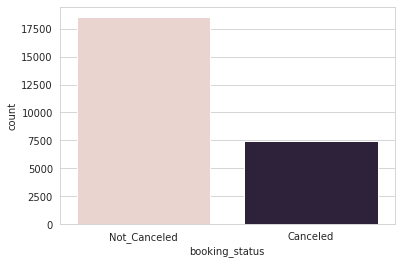

In [ ]:
sns.set_style("whitegrid")
ax = sns.countplot(df['booking_status'], palette=sns.cubehelix_palette(2))


The two classes were not distributed balanced so the data may be imbalanced. 

Text(0.5, 1.0, 'Number of Adults and Children')

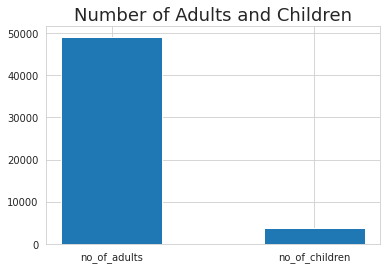

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(2), [df['no_of_adults'].sum(), df['no_of_children'].sum()], width=0.5)
plt.xticks(np.arange(2), ('no_of_adults','no_of_children'))
plt.title('Number of Adults and Children', fontsize=18)

More adults has booked a room than children. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Average Prices of Each Room Types')

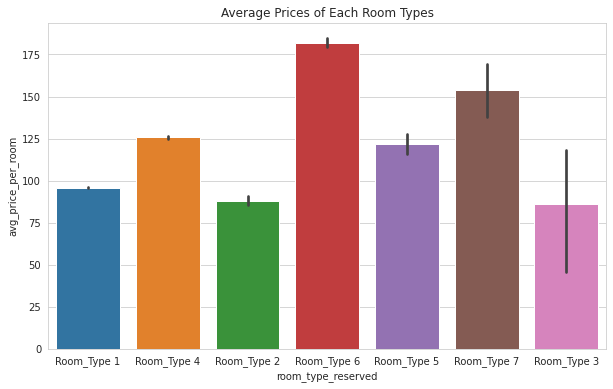

In [ ]:
plt.figure(figsize=(10,6))
ax =  sns.barplot(df['room_type_reserved'], df['avg_price_per_room'])
plt.title('Average Prices of Each Room Types')

Room Type 6 is the most expensive one, followed by Room Type 7.  Room Type 2 or Type 3 is the cheapest one. 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Special Request - Cancellation')

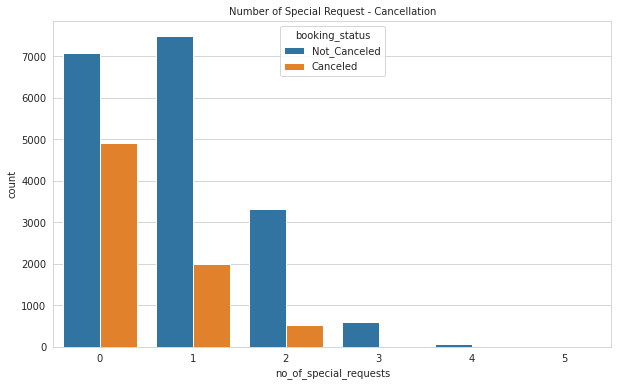

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(df['no_of_special_requests'], hue=df['booking_status'])
plt.title('Number of Special Request - Cancellation', fontsize=10)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Cancelation Situation by Months')

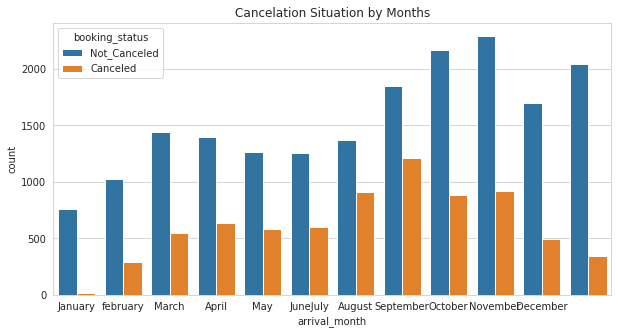

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(df['arrival_month'], hue=df['booking_status'])
plt.xticks(np.arange(0,12),["January", "february", "March", "April","May","June"
"July","August","September","October","November","December"])
plt.title('Cancelation Situation by Months')

This chart shows the cancellation occurences by months.

### **Identifying Outliers**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lead Time by Cancellation')

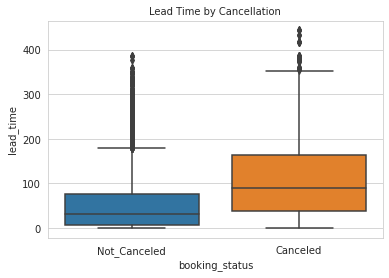

In [ ]:
# deploying a boxplot
sns.boxplot(df['booking_status'], df['lead_time'])
plt.title('Lead Time by Cancellation', fontsize=10)

There are outliers in this data. 

I can also say that as the lead time increases, the possibiity of canceling increases as well. 